## Imports

In [ ]:
#IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import csv

from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Dense, Flatten 
from keras.layers import Dropout
from keras import regularizers

from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from skimage.util import random_noise
import matplotlib.pyplot as plt
import random

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Acceso a datos

In [ ]:
# path relativo a google drive
path = 'drive/MyDrive/'
# cargar los datos respectivos 
dict_stamps = np.load(path+'dict_stamps.npz')
ids_train = open(path+'ids_train.txt')
ids_test = open(path+'ids_test.txt')
csv_tags = pd.read_csv(path+'CANDELS_trainset_labels.csv')

## Constantes 

In [ ]:
#DATA & CONST
#cantidades de imagenes 
TRAINING_CAR = 6431
TEST_CAR = 1136

#scaling image size 40x40 - 96x96
MAX_IMAGE_SIZE = 90
CATEGORY_COUNT = 5

# variables del modelo
PADDING_VALUE = 0
LEARNING_RATE = 0.0001
NORMALIZING_VALUE = 255

#inicializar arreglos vacios
train_images = np.empty((TRAINING_CAR, MAX_IMAGE_SIZE, MAX_IMAGE_SIZE))
train_labels = np.empty((TRAINING_CAR, CATEGORY_COUNT))

test_images = np.empty((TEST_CAR, MAX_IMAGE_SIZE, MAX_IMAGE_SIZE))
csv_tags.set_index(csv_tags.columns[0], inplace=True)

## Procesamiento de datos

In [ ]:
#Escalar las imagenes de entrenamiento 
i = 0
for item in ids_train:
  item = item.strip()
  image = dict_stamps[item]

  image[np.isnan(image)] = PADDING_VALUE

  scale_factor = MAX_IMAGE_SIZE / max(image.shape)
  image = resize(image, (round(image.shape[0] * scale_factor), round(image.shape[1] * scale_factor)))


  pad_width = ((0, max(0, MAX_IMAGE_SIZE - image.shape[0])), (0, max(0, MAX_IMAGE_SIZE - image.shape[1])))
  image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=PADDING_VALUE)

  train_labels[i] = csv_tags.loc[item]
  train_images[i] = image
  i += 1

#Escalar las imagenes de testeo 
i = 0
for item in ids_test:
  item = item.strip()
  image = dict_stamps[item]

  image[np.isnan(image)] = PADDING_VALUE


  scale_factor = MAX_IMAGE_SIZE / max(image.shape)
  image = resize(image, (round(image.shape[0] * scale_factor), round(image.shape[1] * scale_factor)))


  pad_width = ((0, max(0, MAX_IMAGE_SIZE - image.shape[0])), (0, max(0, MAX_IMAGE_SIZE - image.shape[1])))
  image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=PADDING_VALUE)

  test_images[i] = image
  i += 1


## Data augmentation

In [ ]:
#DATA AUGMENTATION 
augmented_images = np.empty((TRAINING_CAR, MAX_IMAGE_SIZE, MAX_IMAGE_SIZE))
#Flip de imagenes en horizontal y vertical
for i in range(train_images.shape[0]):
    image = train_images[i]
    flip_axis = np.random.choice([0, 1])
    flipped_image = np.flip(image, axis=flip_axis) 
    augmented_images[i] = flipped_image

train_images = np.concatenate((train_images, augmented_images),axis=0)
#agregar ruido 
noisy_images = train_images + np.random.normal(0,1,train_images[0].shape)*0.01
train_images = np.concatenate((train_images, noisy_images),axis=0)

train_images = np.concatenate((train_images, np.rot90(train_images, k=1, axes=(1, 2))),axis=0)

train_labels = np.concatenate((train_labels, train_labels, train_labels, train_labels,train_labels, train_labels,train_labels, train_labels),axis=0)

In [ ]:
x_train = train_images
x_test = test_images

# x_train /= NORMALIZING_VALUE
# x_test /= NORMALIZING_VALUE

y_train = train_labels

In [ ]:
class_names = ['p_smooth', 'p_features', 'p_irregular', 'p_point_source', 'p_unclassifiable']

## Inicializar modelo, optimizador, perdida y metricas

In [ ]:
model = keras.models.Sequential()

loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
optim = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

metrics = [keras.metrics.RootMeanSquaredError(), "mse", "mae"]

## Modelo

In [ ]:
# Tres capas convolucionales con capas de pooling respectivas  
model.add(layers.Conv2D(8, (3,3), strides=(1,1), padding = "valid", input_shape = (MAX_IMAGE_SIZE,MAX_IMAGE_SIZE,1)))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(16, 2, activation='relu'))
model.add(layers.Conv2D(16, 2, activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(32, 2, activation='relu'))
model.add(layers.Conv2D(32, 2, activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(64, 2, activation='relu'))
model.add(layers.Conv2D(64, 2, activation='relu'))
model.add(layers.MaxPool2D(2, 2))
model.add(layers.Conv2D(256, 2, activation='relu'))
model.add(layers.Conv2D(256, 2, activation='relu'))
#model.add(layers.MaxPool2D(2, 2))
# Capa de aplanamiento 
model.add(layers.Flatten())
# Capa regularizadora
model.add(layers.Dense(32, activation='relu', input_shape=(MAX_IMAGE_SIZE,MAX_IMAGE_SIZE,1), kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.2))
model.add(layers.Dense(64, activation='relu', input_shape=(MAX_IMAGE_SIZE,MAX_IMAGE_SIZE,1), kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.2))
# Capa densa final 
model.add(layers.Dense(5 , activation = 'softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 16)        528       
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 16)        1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 32)        2

## Compilacion 

In [ ]:
model.compile(optimizer = optim, loss = loss, metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

batch size, epocas, tamaño de validacion

In [ ]:
batch_size = 64 
epochs =  60
validation_size = 0.1

history = model.fit(x_train, y_train, epochs = epochs , batch_size = batch_size, validation_split = validation_size, callbacks=[callback] )

Epoch 1/60
724/724 [==============================] - 16s 12ms/step - loss: 5.4338 - root_mean_squared_error: 0.2343 - mse: 0.0549 - mae: 0.1724 - val_loss: 2.8579 - val_root_mean_squared_error: 0.2063 - val_mse: 0.0426 - val_mae: 0.1467
Epoch 2/60
724/724 [==============================] - 6s 9ms/step - loss: 1.4231 - root_mean_squared_error: 0.2139 - mse: 0.0458 - mae: 0.1532 - val_loss: 0.5454 - val_root_mean_squared_error: 0.2128 - val_mse: 0.0453 - val_mae: 0.1533
Epoch 3/60
724/724 [==============================] - 7s 10ms/step - loss: 0.2871 - root_mean_squared_error: 0.2149 - mse: 0.0462 - mae: 0.1540 - val_loss: 0.1039 - val_root_mean_squared_error: 0.2065 - val_mse: 0.0426 - val_mae: 0.1487
Epoch 4/60
724/724 [==============================] - 6s 9ms/step - loss: 0.0630 - root_mean_squared_error: 0.2100 - mse: 0.0441 - mae: 0.1486 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2006 - val_mse: 0.0403 - val_mae: 0.1413
Epoch 5/60
724/724 [==============================] -

## Rendimiento

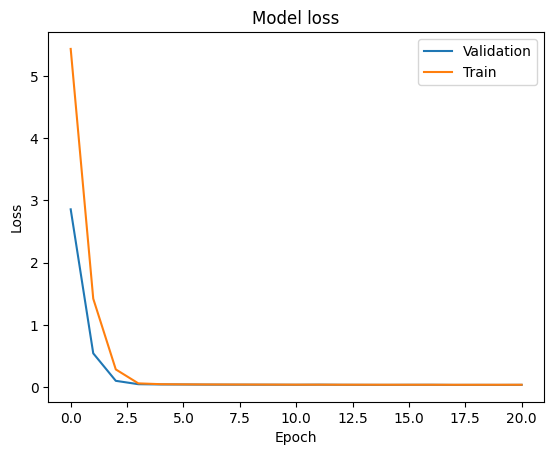

In [ ]:
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend([ 'Validation','Train',], loc='upper right')
plt.show()

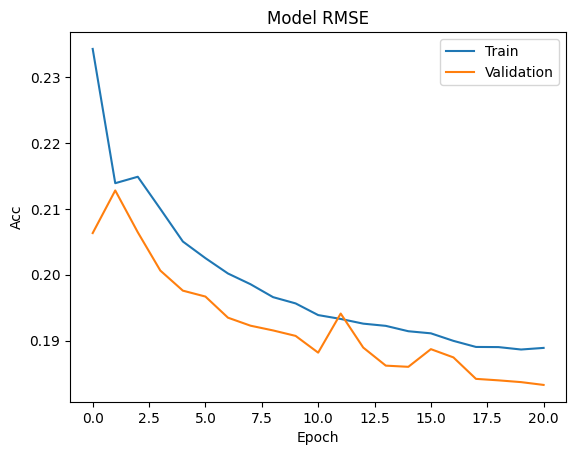

In [ ]:
plt.plot(history.epoch, history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
predictions = model.predict(x_test)
np.set_printoptions(threshold=np.inf)

ids_test = open(path+'ids_test.txt')
headerList = ['ID', 'p_smooth', 'p_features', 'p_irregular', 'p_point_source', 'p_unclassifiable']
i=0
with open('predicted.csv', 'w') as f:
  dw = csv.DictWriter(f, delimiter=',', fieldnames=headerList)
  dw.writeheader()
  for key in ids_test:
    key = key.strip()
    row = [key] + predictions[i].tolist()
    line = ','.join([str(elem) for elem in row]) + '\n'
    f.write(line)
    i += 1

files.download('predicted.csv')

36/36 [==============================] - 1s 7ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>